## LIBRARY

In [ ]:
!pip install qiskit qiskit-aer --quiet
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from qiskit import QuantumCircuit, transpile



from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00


## Load and Display Chest X-Ray Image

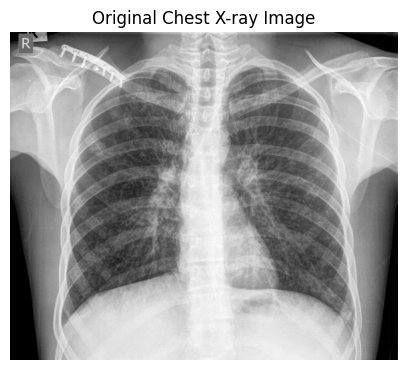

In [ ]:
# Load image
img = Image.open("/content/chestpqip.jpeg").convert("L")

plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Original Chest X-ray Image")
plt.axis("off")
plt.show()


##Resize and Extract Small Image Patch

###Extracts a 4×4 patch

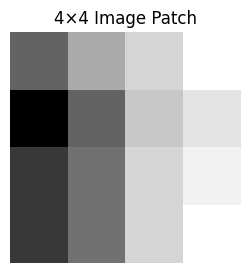

array([[231, 236, 239, 242],
       [224, 231, 238, 240],
       [228, 232, 239, 241],
       [228, 232, 239, 242]], dtype=uint8)

In [ ]:
# Resize image
img_resized = img.resize((64, 64))

# Extract 4x4 patch from center
w, h = img_resized.size
patch = img_resized.crop((30, 30, 34, 34))

patch_array = np.array(patch)

plt.figure(figsize=(3,3))
plt.imshow(patch_array, cmap="gray")
plt.title("4×4 Image Patch")
plt.axis("off")
plt.show()

patch_array


##Normalize Image Patch

In [ ]:
# Normalize pixel values
patch_norm = patch_array / np.linalg.norm(patch_array)

patch_norm


array([[0.24554662, 0.25086148, 0.2540504 , 0.25723932],
       [0.23810582, 0.24554662, 0.25298743, 0.25511337],
       [0.24235771, 0.2466096 , 0.2540504 , 0.25617635],
       [0.24235771, 0.2466096 , 0.2540504 , 0.25723932]])

##Add Gaussian Noise

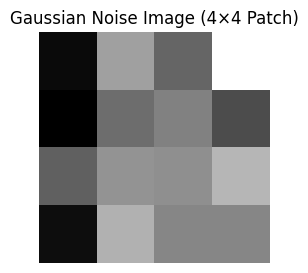

Original 4×4 Image Patch Matrix:
[[231 236 239 242]
 [224 231 238 240]
 [228 232 239 241]
 [228 232 239 242]]

Gaussian Noise Matrix:
[[-18.20716036   1.89898846 -10.99165201  11.99434481]
 [-13.04233961  -1.57549005  -5.33037266 -16.25139884]
 [ -0.7596605    3.99264978  -3.93902388   0.59824788]
 [-14.71266409   8.81676265  -5.49995373  -8.34868485]]

Gaussian Noisy Image Matrix:
[[212.79283964 237.89898846 228.00834799 253.99434481]
 [210.95766039 229.42450995 232.66962734 223.74860116]
 [227.2403395  235.99264978 235.06097612 241.59824788]
 [213.28733591 240.81676265 233.50004627 233.65131515]]


In [ ]:
# Add Gaussian noise
gaussian_noise = np.random.normal(0, 10, patch_array.shape)
gaussian_img = patch_array + gaussian_noise

# Show Gaussian noisy image
plt.figure(figsize=(3,3))
plt.imshow(gaussian_img, cmap="gray")
plt.title("Gaussian Noise Image (4×4 Patch)")
plt.axis("off")
plt.show()

# Print original and noisy matrices
print("Original 4×4 Image Patch Matrix:")
print(patch_array)

print("\nGaussian Noise Matrix:")
print(gaussian_noise)

print("\nGaussian Noisy Image Matrix:")
print(gaussian_img)


##Add Salt-and-Pepper Noise

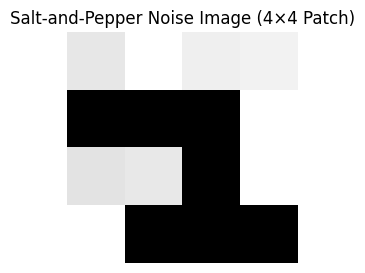

Original 4×4 Image Patch Matrix:
[[231 236 239 242]
 [224 231 238 240]
 [228 232 239 241]
 [228 232 239 242]]

Salt-and-Pepper Noisy Image Matrix:
[[231 255 239 242]
 [  0   0   0 255]
 [228 232   0 255]
 [255   0   0   0]]


In [ ]:
# Fix random seed for reproducibility
np.random.seed(42)

# Salt-and-pepper noise
sp_img = patch_array.copy()
prob = 0.5   # higher probability for small 4x4 image

for i in range(sp_img.shape[0]):
    for j in range(sp_img.shape[1]):
        r = np.random.rand()
        if r < prob/2:
            sp_img[i, j] = 0          # Pepper
        elif r > 1 - prob/2:
            sp_img[i, j] = 255        # Salt

# Display noisy image
plt.figure(figsize=(3,3))
plt.imshow(sp_img, cmap="gray")
plt.title("Salt-and-Pepper Noise Image (4×4 Patch)")
plt.axis("off")
plt.show()

# Print matrices
print("Original 4×4 Image Patch Matrix:")
print(patch_array)

print("\nSalt-and-Pepper Noisy Image Matrix:")
print(sp_img)


##Quantum State Preparation
###Encodes image data into a quantum state.

In [ ]:
from qiskit.quantum_info import Statevector

def prepare_quantum_state(patch_array):
    """
    Prepare a 4-qubit quantum state using amplitude encoding
    from a 4×4 image patch.
    """
    # Flatten and normalize
    data = patch_array.flatten().astype(float)
    data = data / np.linalg.norm(data)

    # Create circuit
    qc = QuantumCircuit(4)
    qc.initialize(data, range(4))
    qc = qc.decompose()

    # Print statevector
    state = Statevector.from_instruction(qc)
    print("\nQuantum Statevector (Amplitude Encoding):")
    for i, amp in enumerate(state.data):
        print(f"|{format(i, '04b')}> : {amp}")

    return qc

a=prepare_quantum_state(patch_array)



Quantum Statevector (Amplitude Encoding):
|0000> : (0.24554662272525157-2.7635570225794953e-12j)
|0001> : (0.25086148468260067+2.638750171042275e-12j)
|0010> : (0.25405040186074374+2.8086190425471637e-12j)
|0011> : (0.2572393190454835-2.7264143294412752e-12j)
|0100> : (0.23810581597299618+3.666927250586165e-14j)
|0101> : (0.24554662272203553-3.9865926972128465e-14j)
|0110> : (0.25298742947126285+2.2353030117282186e-14j)
|0111> : (0.255113374256718-1.3038443586021542e-14j)
|1000> : (0.2423577055485924+7.539442114619445e-13j)
|1001> : (0.24660959511024697-7.211303333487197e-13j)
|1010> : (0.25405040185905003-8.692834823381351e-13j)
|1011> : (0.25617634665435607+8.523224316848486e-13j)
|1100> : (0.2423577055439158+1.95292275886723e-14j)
|1101> : (0.24660959511482974-1.3392799289538718e-15j)
|1110> : (0.2540504018639819+8.831173148788645e-15j)
|1111> : (0.2572393190421662-3.81980135173881e-14j)


##QFT on Clean Image

In [ ]:
def apply_qft(qc):
    """
    Apply standard Quantum Fourier Transform (QFT).
    """
    n = qc.num_qubits

    for qubit in range(n):
        for j in range(qubit):
            angle = np.pi / (2 ** (qubit - j))
            qc.cp(angle, qubit, j)
        qc.h(qubit)

    for i in range(n // 2):
        qc.swap(i, n - i - 1)

    return qc
from qiskit_aer import Aer
from qiskit import transpile

def execute_qft(qc, shots=10000):
    qc_meas = qc.copy()
    qc_meas.measure_all()

    backend = Aer.get_backend("aer_simulator")
    tqc = transpile(qc_meas, backend)
    result = backend.run(tqc, shots=shots).result()

    return result.get_counts()
def analyze_qft_results(counts, title):
    total_shots = sum(counts.values())

    print(f"\n=== {title} ===")
    print(f"Total shots: {total_shots}")
    print(f"Distinct states measured: {len(counts)}")

    probabilities = {k: v/total_shots for k, v in counts.items()}
    sorted_probs = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 5 dominant frequency states:")
    for state, prob in sorted_probs[:5]:
        print(f"  |{state}> : {prob:.4f}")

    return probabilities
qc_clean = prepare_quantum_state(patch_array)
qc_clean = apply_qft(qc_clean)

counts_clean = execute_qft(qc_clean, shots=10000)
clean_probs = analyze_qft_results(counts_clean, "Clean Image QFT Analysis")



Quantum Statevector (Amplitude Encoding):
|0000> : (0.24554662272525157-2.7635570225794953e-12j)
|0001> : (0.25086148468260067+2.638750171042275e-12j)
|0010> : (0.25405040186074374+2.8086190425471637e-12j)
|0011> : (0.2572393190454835-2.7264143294412752e-12j)
|0100> : (0.23810581597299618+3.666927250586165e-14j)
|0101> : (0.24554662272203553-3.9865926972128465e-14j)
|0110> : (0.25298742947126285+2.2353030117282186e-14j)
|0111> : (0.255113374256718-1.3038443586021542e-14j)
|1000> : (0.2423577055485924+7.539442114619445e-13j)
|1001> : (0.24660959511024697-7.211303333487197e-13j)
|1010> : (0.25405040185905003-8.692834823381351e-13j)
|1011> : (0.25617634665435607+8.523224316848486e-13j)
|1100> : (0.2423577055439158+1.95292275886723e-14j)
|1101> : (0.24660959511482974-1.3392799289538718e-15j)
|1110> : (0.2540504018639819+8.831173148788645e-15j)
|1111> : (0.2572393190421662-3.81980135173881e-14j)

=== Clean Image QFT Analysis ===
Total shots: 10000
Distinct states measured: 3

Top 5 dominan

In [ ]:
# Build circuit for clean image
qc_clean = prepare_quantum_state(patch_norm)
qc_clean = apply_qft(qc_clean)
qc_clean.measure_all()

# Transpile and run with MORE shots for better statistics
backend = Aer.get_backend('qasm_simulator')
qc_clean = transpile(qc_clean, backend)

# INCREASE SHOTS SIGNIFICANTLY
result_clean = backend.run(qc_clean, shots=10000).result()  # 10000 is fine
counts_clean = result_clean.get_counts()

# Debug: Print the counts to see what's actually measured
print("\nRaw measurement counts:")
print(counts_clean)

# If counts is empty, something failed — add error check
if not counts_clean:
    print("ERROR: No measurements returned! Check circuit or backend.")

# === IMPROVED PLOTTING WITH INSET (Option 1) ===
fig, ax = plt.subplots(figsize=(12, 6))

plot_histogram(counts_clean, ax=ax)
ax.set_title("QFT Measurement Results - Clean Image (Frequency Domain)")
ax.set_ylabel("Counts")

# Add inset to zoom on the low-count (high-frequency) states
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper right')
plot_histogram(counts_clean, ax=inset_ax)
inset_ax.set_ylim(0, 10)  # Zoom to clearly see the tiny bars (adjust if needed)
inset_ax.set_title("Zoom: High-Frequency Components")

# Optional: draw lines connecting the inset to the main plot
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

# Optional: Sort and show probabilities
total_shots = sum(counts_clean.values())
print("\nTop probability states (should show dominant low frequencies):")
sorted_counts = sorted(counts_clean.items(), key=lambda x: x[1], reverse=True)
for state, count in sorted_counts[:8]:
    print(f"|{state}> : {count} counts ({count/total_shots:.4f} probability)")


Quantum Statevector (Amplitude Encoding):
|0000> : (0.24554662272525157-2.7635570225794953e-12j)
|0001> : (0.25086148468260067+2.638750171042275e-12j)
|0010> : (0.25405040186074374+2.8086190425471637e-12j)
|0011> : (0.2572393190454835-2.7264143294412752e-12j)
|0100> : (0.23810581597299618+3.666927250586165e-14j)
|0101> : (0.24554662272203553-3.9865926972128465e-14j)
|0110> : (0.25298742947126285+2.2353030117282186e-14j)
|0111> : (0.255113374256718-1.3038443586021542e-14j)
|1000> : (0.2423577055485924+7.539442114619445e-13j)
|1001> : (0.24660959511024697-7.211303333487197e-13j)
|1010> : (0.25405040185905003-8.692834823381351e-13j)
|1011> : (0.25617634665435607+8.523224316848486e-13j)
|1100> : (0.2423577055439158+1.95292275886723e-14j)
|1101> : (0.24660959511482974-1.3392799289538718e-15j)
|1110> : (0.2540504018639819+8.831173148788645e-15j)
|1111> : (0.2572393190421662-3.81980135173881e-14j)

Raw measurement counts:
{'0100': 4, '0110': 1, '1111': 1, '0111': 2, '0000': 9992}


/tmp/ipython-input-517833563.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Top probability states (should show dominant low frequencies):
|0000> : 9992 counts (0.9992 probability)
|0100> : 4 counts (0.0004 probability)
|0111> : 2 counts (0.0002 probability)
|0110> : 1 counts (0.0001 probability)
|1111> : 1 counts (0.0001 probability)


##QFT on Gaussian Noise Image


Quantum Statevector (Amplitude Encoding):
|0000> : (0.23036376067549913+1.50353077715107e-14j)
|0001> : (0.2575429969150801-3.245846500533719e-14j)
|0010> : (0.24683565762514817-2.4873518352055173e-14j)
|0011> : (0.27496739345458715+3.125562040892387e-14j)
|0100> : (0.2283770453662976-2.0039823936446234e-14j)
|0101> : (0.2483687561797484+3.5903674270870965e-14j)
|0110> : (0.25188183230830485+1.3554233394693564e-14j)
|0111> : (0.242224171154454-2.13213904558195e-14j)
|1000> : (0.24600423244973707-1.4437167306037198e-14j)
|1001> : (0.2554792463294078+2.03463086070705e-14j)
|1010> : (0.2544706416825856+3.370773406703229e-14j)
|1011> : (0.26154771490416334-2.917185522002957e-14j)
|1100> : (0.23089908894133168+2.7237623565107345e-14j)
|1101> : (0.2607017001708488-2.3793935686516067e-14j)
|1110> : (0.2527808213327879-2.8355339634818346e-14j)
|1111> : (0.25294458091896904+1.945332653929333e-14j)

Raw measurement counts (Gaussian Noise):
{'0100': 1, '1010': 1, '1000': 4, '0011': 2, '1011': 1,

/tmp/ipython-input-3660323642.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


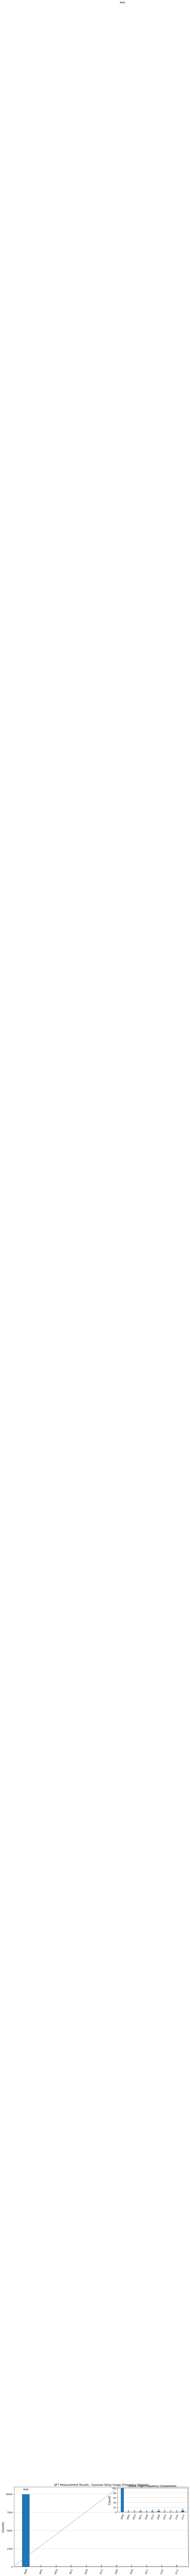

In [ ]:
# === Gaussian Noise QFT (Strong noise, std=10) ===

# Step 1: Prepare the normalized Gaussian noisy patch
# Use the gaussian_img you created earlier (with np.random.normal(0, 10, ...))
gaussian_flat = gaussian_img.flatten().astype(float)  # Convert to float for safety
gaussian_norm = gaussian_flat / np.linalg.norm(gaussian_flat)  # L2 normalization

# Step 2: Build the quantum circuit
qc_gauss = prepare_quantum_state(gaussian_norm)  # Your existing function
qc_gauss = apply_qft(qc_gauss)                   # Your existing QFT function
qc_gauss.measure_all()                          # Add measurements

# Step 3: Transpile and execute on simulator
backend = Aer.get_backend('qasm_simulator')     # Same backend as before
qc_gauss = transpile(qc_gauss, backend)

result_gauss = backend.run(qc_gauss, shots=10000).result()
counts_gauss = result_gauss.get_counts()

# Step 4: Debug — Print raw counts and top states
print("\nRaw measurement counts (Gaussian Noise):")
print(counts_gauss)

total_shots = sum(counts_gauss.values())
print("\nTop probability states (Gaussian Noise):")
sorted_gauss = sorted(counts_gauss.items(), key=lambda x: x[1], reverse=True)
for state, count in sorted_gauss[:8]:
    print(f"|{state}> : {count} counts ({count/total_shots:.4f} probability)")

# Step 5: Plot with inset zoom (same style as before)
fig, ax = plt.subplots(figsize=(12, 6))
plot_histogram(counts_gauss, ax=ax)
ax.set_title("QFT Measurement Results - Gaussian Noisy Image (Frequency Domain)")
ax.set_ylabel("Counts")

# Inset for high-frequency components (Gaussian has more than clean, less than S&P)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper right')
plot_histogram(counts_gauss, ax=inset_ax)
inset_ax.set_ylim(0, 100)  # Adjust if needed — expect bars up to ~50–80
inset_ax.set_title("Zoom: High-Frequency Components")
mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

##QFT on Salt-and-Pepper Noisy Image


Quantum Statevector (Amplitude Encoding):
|0000> : (0.3158302763274658-7.771561172376096e-16j)
|0001> : (0.34864381153031265-2.220446049250313e-16j)
|0010> : (0.3267681213950821-1.3600232051658168e-15j)
|0011> : (0.33086981329543375+4.579669976578771e-16j)
|0100> : (1.1102230246251525e-16+6.373224301807671e-16j)
|0101> : (-2.465190328815662e-32+1.4791141972893971e-31j)
|0110> : (9.43689570931383e-16+3.469446951953614e-16j)
|0111> : (0.348643811530316+5.551115123125783e-16j)
|1000> : (0.31172858442710283+2.220446049250313e-16j)
|1001> : (0.3171975069609171-7.91033905045424e-16j)
|1010> : (-2.8033131371785203e-15+4.3021142204224816e-16j)
|1011> : (0.3486438115303157+6.626643678231403e-16j)
|1100> : (0.3486438115303152-8.534839501805891e-16j)
|1101> : (-1.3877787807814457e-17-1.942890293094024e-16j)
|1110> : (1.110223024625157e-16-8.251936067343198e-17j)
|1111> : (3.4512664603419266e-31-1.756448109281159e-31j)

Raw measurement counts (Salt-and-Pepper):
{'0100': 4, '1010': 116, '0000': 56

/tmp/ipython-input-1130450365.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


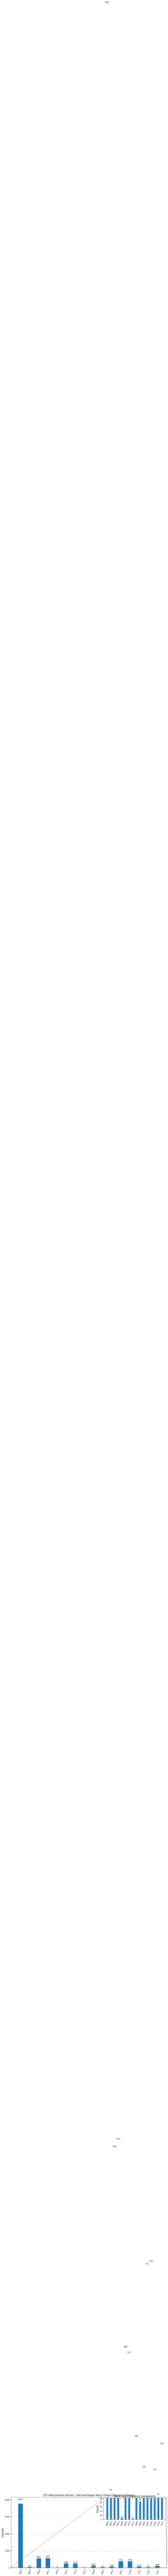


Top probability states (Salt-and-Pepper):
|0000> : 5657 counts (0.5657 probability)
|0011> : 853 counts (0.0853 probability)
|0010> : 836 counts (0.0836 probability)
|1100> : 578 counts (0.0578 probability)
|1011> : 572 counts (0.0572 probability)
|0101> : 386 counts (0.0386 probability)
|0110> : 373 counts (0.0373 probability)
|1000> : 185 counts (0.0185 probability)


In [ ]:
# === Salt-and-Pepper Noisy Image QFT ===

# Normalize the salt-and-pepper noisy patch
# Important: sp_img contains 0s and 255s → after flattening, many zeros → norm very small for zero entries
# But some amplitudes become exactly zero → Qiskit initialize struggles with exact zeros sometimes
# Add small epsilon to avoid numerical issues (common trick)
sp_flat = sp_img.flatten().astype(float)

sp_norm = sp_flat / np.linalg.norm(sp_flat)

# If norm is zero (unlikely here), add tiny epsilon
if np.linalg.norm(sp_norm) == 0:
    sp_norm += 1e-10
sp_norm /= np.linalg.norm(sp_norm)  # renormalize

# Build circuit
qc_sp = prepare_quantum_state(sp_norm)  # your function already decomposes initialize → no 'state_preparation' gate
qc_sp = apply_qft(qc_sp)
qc_sp.measure_all()

# Use the SAME backend as before and transpile (critical!)
qc_sp = transpile(qc_sp, backend)

# Run with enough shots
result_sp = backend.run(qc_sp, shots=10000).result()
counts_sp = result_sp.get_counts()

# Debug print
print("\nRaw measurement counts (Salt-and-Pepper):")
print(counts_sp)

# === IMPROVED PLOTTING WITH INSET ===
fig, ax = plt.subplots(figsize=(12, 6))

plot_histogram(counts_sp, ax=ax)
ax.set_title("QFT Measurement Results - Salt-and-Pepper Noisy Image (Frequency Domain)")
ax.set_ylabel("Counts")

# Inset zoom for high-frequency components
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper right')
plot_histogram(counts_sp, ax=inset_ax)
inset_ax.set_ylim(0, 50)  # Adjust based on your noise level — S&P usually has more high-freq energy
inset_ax.set_title("Zoom: High-Frequency Components")

mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()

# Top states
total_shots = sum(counts_sp.values())
print("\nTop probability states (Salt-and-Pepper):")
sorted_counts = sorted(counts_sp.items(), key=lambda x: x[1], reverse=True)
for state, count in sorted_counts[:8]:
    print(f"|{state}> : {count} counts ({count/total_shots:.4f} probability)")

##Comparison Plot

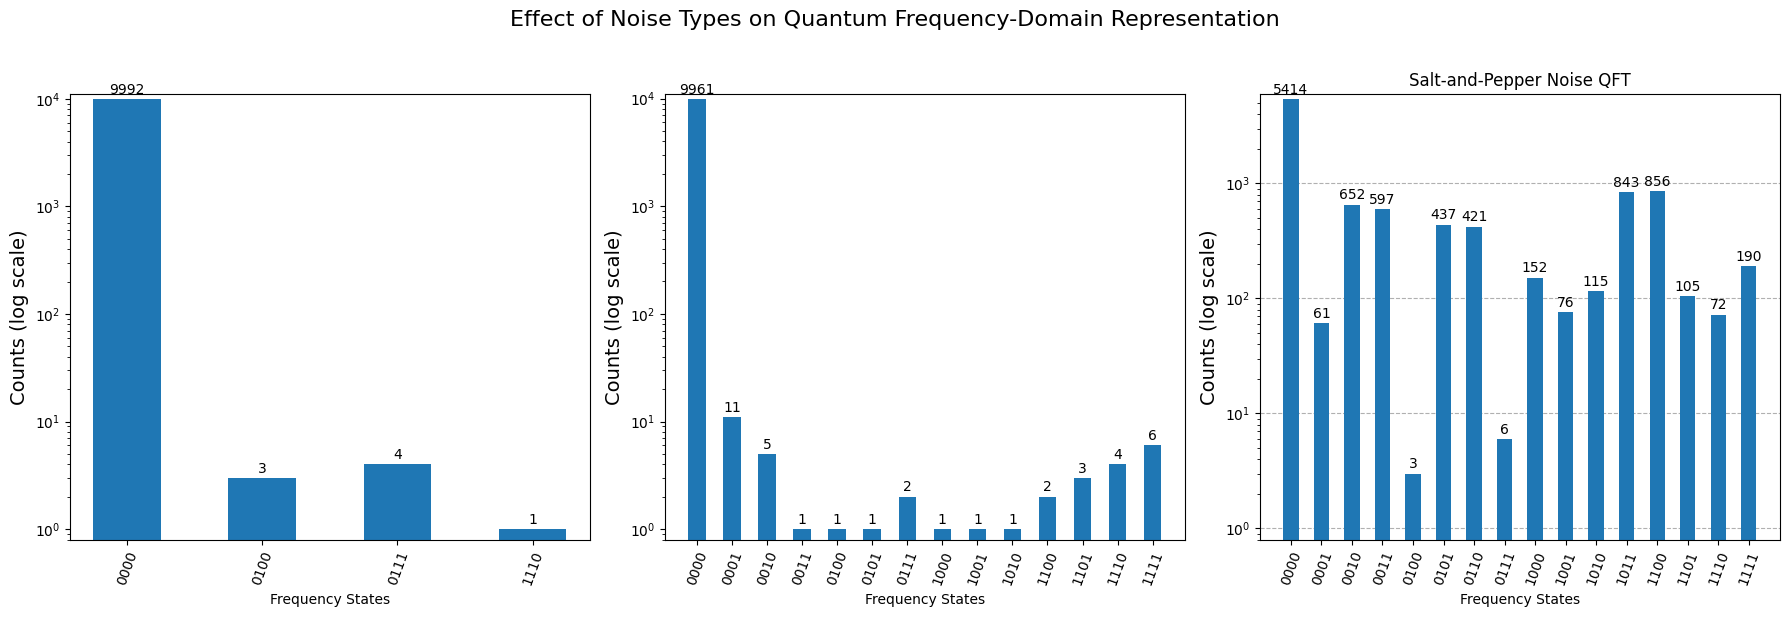

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
counts_list = [counts_clean, counts_gauss, counts_sp]
titles = ["Clean Image QFT", "Gaussian Noise QFT", "Salt-and-Pepper Noise QFT"]

for ax, counts, title in zip(axes, counts_list, titles):
    plot_histogram(counts, ax=ax, title=title)
    ax.set_yscale('log')
    ax.set_ylim(bottom=0.8)
    ax.set_xlabel("Frequency States")
    ax.set_ylabel("Counts (log scale)")

plt.suptitle("Effect of Noise Types on Quantum Frequency-Domain Representation", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# === Generate Text-Based QFT Circuit Diagram (No Extra Install Needed) ===
from qiskit import QuantumCircuit

# Create a 4-qubit circuit and apply your QFT function
qc_qft = QuantumCircuit(4)
qc_qft = apply_qft(qc_qft)  # Your existing apply_qft function

# Print the text diagram
print("Quantum Fourier Transform (QFT) Circuit for 4 Qubits ")
print(qc_qft.draw('text'))



Quantum Fourier Transform (QFT) Circuit for 4 Qubits 
     ┌───┐                                                                     »
q_0: ┤ H ├─■─────────────■─────────────────■───────────────────────────────────»
     └───┘ │P(π/2) ┌───┐ │                 │                                   »
q_1: ──────■───────┤ H ├─┼────────■────────┼─────────────■──────────────────X──»
                   └───┘ │P(π/4)  │P(π/2)  │       ┌───┐ │                  │  »
q_2: ────────────────────■────────■────────┼───────┤ H ├─┼────────■─────────X──»
                                           │P(π/8) └───┘ │P(π/4)  │P(π/2) ┌───┐»
q_3: ──────────────────────────────────────■─────────────■────────■───────┤ H ├»
                                                                          └───┘»
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«        



=== Classical FFT: Clean Image ===
Top 5 dominant frequency components:
  Index 0 (|{:04b}>.format(i)): 15.9818
  Index 12 (|{:04b}>.format(i)): 0.0077
  Index 4 (|{:04b}>.format(i)): 0.0077
  Index 8 (|{:04b}>.format(i)): 0.0023
  Index 13 (|{:04b}>.format(i)): 0.0001


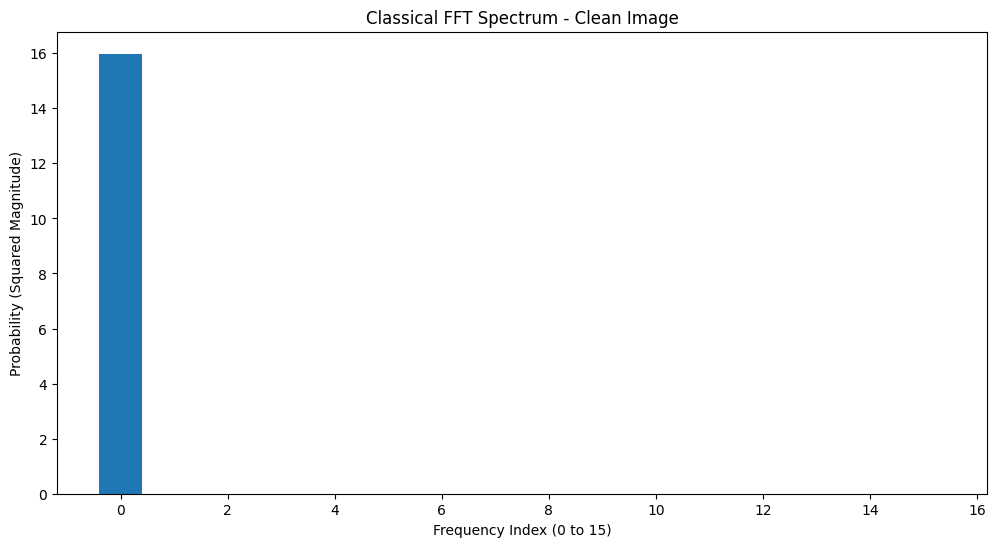


=== Classical FFT: Gaussian Noisy Image ===
Top 5 dominant frequency components:
  Index 0 (|{:04b}>.format(i)): 15.9361
  Index 15 (|{:04b}>.format(i)): 0.0096
  Index 1 (|{:04b}>.format(i)): 0.0096
  Index 12 (|{:04b}>.format(i)): 0.0084
  Index 4 (|{:04b}>.format(i)): 0.0084


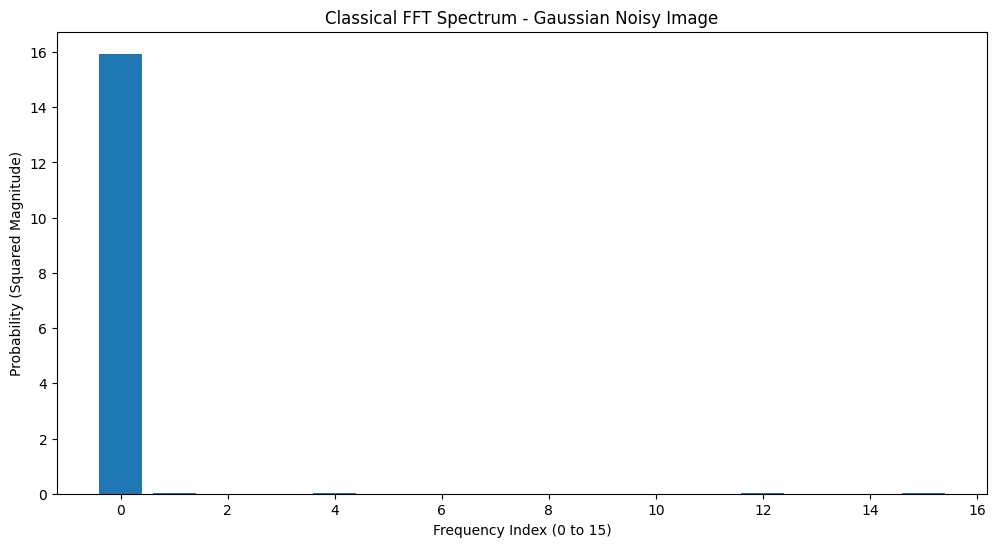


=== Classical FFT: Salt-and-Pepper Noisy Image ===
Top 5 dominant frequency components:
  Index 0 (|{:04b}>.format(i)): 8.6967
  Index 13 (|{:04b}>.format(i)): 1.2940
  Index 3 (|{:04b}>.format(i)): 1.2940
  Index 14 (|{:04b}>.format(i)): 1.0646
  Index 2 (|{:04b}>.format(i)): 1.0646


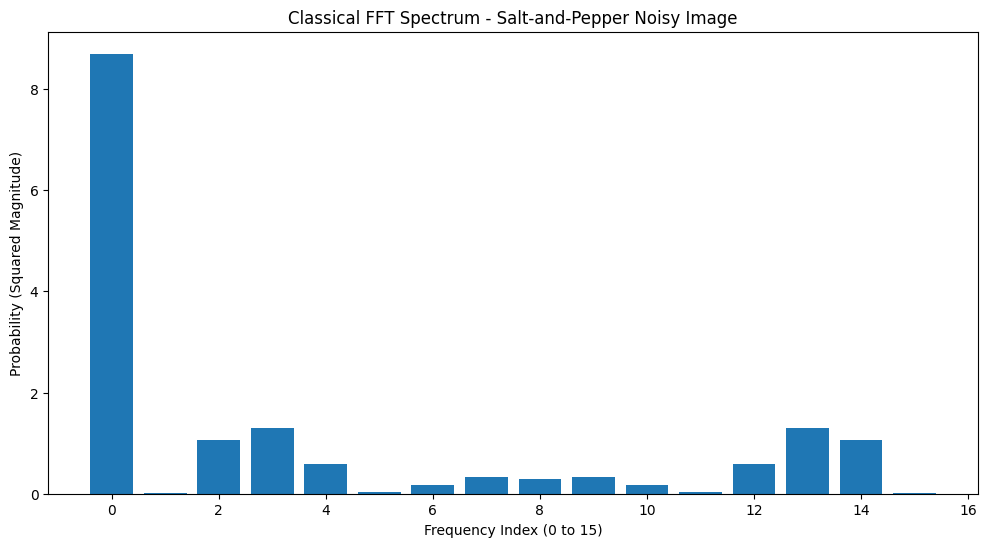

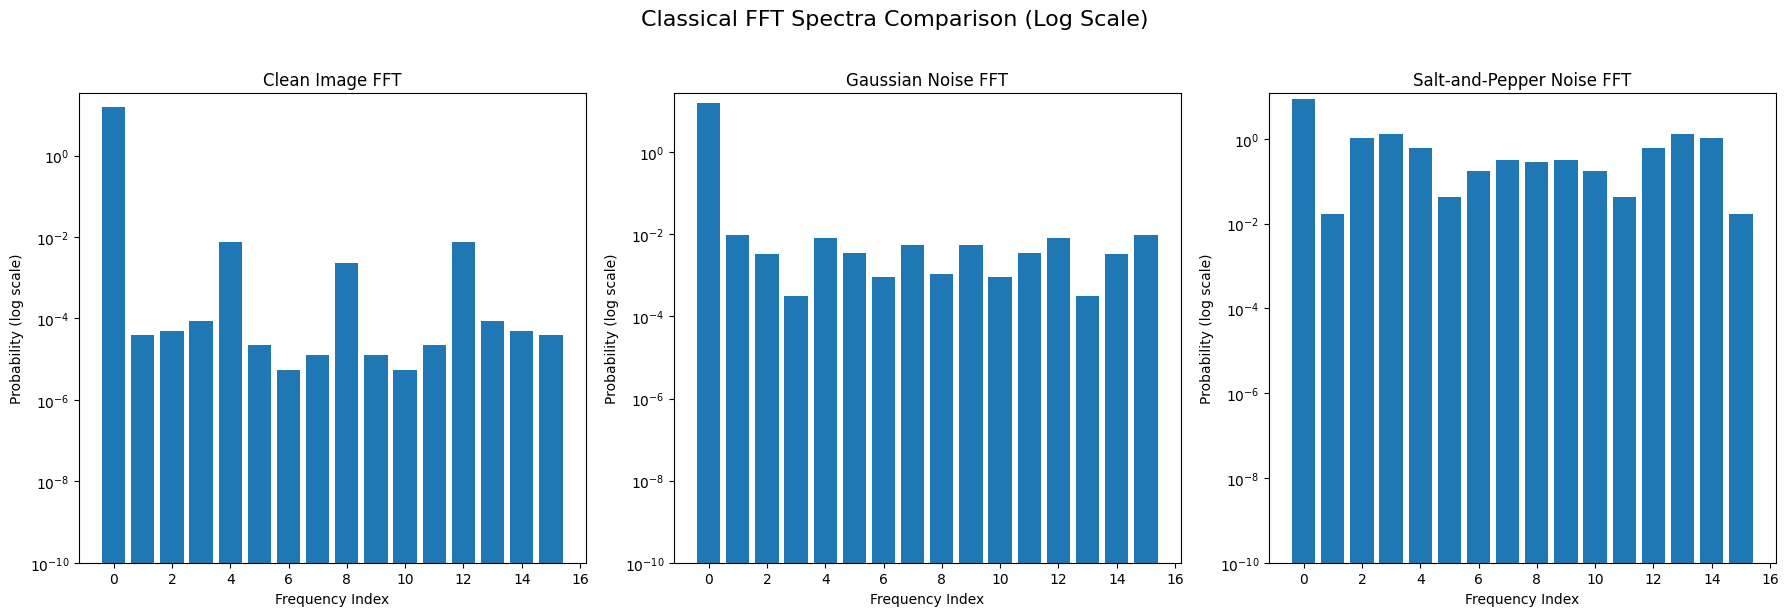

In [ ]:
# Classical Fourier Transform equivalent (1D FFT on flattened normalized data)
# This mirrors the QFT applied to the amplitude-encoded statevector,
# where the FFT coefficients' squared magnitudes give the exact probabilities
# in the frequency basis (without sampling noise from measurements).

import numpy as np
import matplotlib.pyplot as plt

def classical_fft_analysis(norm_data_flat, title, log_scale=False):
    """
    Compute classical 1D FFT on flattened normalized data.
    Returns the squared magnitudes (exact "probabilities").
    """
    # Ensure input is 1D flattened and normalized
    if norm_data_flat.ndim > 1:
        norm_data_flat = norm_data_flat.flatten()
    norm_data_flat = norm_data_flat / np.linalg.norm(norm_data_flat)

    # Compute FFT
    fft_result = np.fft.fft(norm_data_flat)

    # Squared magnitudes (analogous to QFT measurement probabilities)
    probs = np.abs(fft_result)**2

    # Sort and print top states for analysis
    print(f"\n=== Classical FFT: {title} ===")
    indices = np.argsort(probs)[::-1]  # Descending order
    print("Top 5 dominant frequency components:")
    for i in indices[:5]:
        print(f"  Index {i} (|{{:04b}}>.format(i)): {probs[i]:.4f}")

    # Plot bar chart (linear or log scale)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(probs)), probs)
    ax.set_xlabel("Frequency Index (0 to 15)")
    ax.set_ylabel("Probability (Squared Magnitude)")
    ax.set_title(f"Classical FFT Spectrum - {title}")
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylim(bottom=1e-10)
    plt.show()

    return probs

# Prepare flattened normalized data for each case
# Note: We flatten here to match the quantum amplitude encoding (1D over 16 elements)

# Clean
clean_flat = patch_array.flatten().astype(float)
clean_norm_flat = clean_flat / np.linalg.norm(clean_flat)
clean_classical_probs = classical_fft_analysis(clean_norm_flat, "Clean Image")

# Gaussian Noise
gauss_flat = gaussian_img.flatten().astype(float)
gauss_norm_flat = gauss_flat / np.linalg.norm(gauss_flat)
gauss_classical_probs = classical_fft_analysis(gauss_norm_flat, "Gaussian Noisy Image")

# Salt-and-Pepper Noise
sp_flat = sp_img.flatten().astype(float)
sp_norm_flat = sp_flat / np.linalg.norm(sp_flat)
sp_classical_probs = classical_fft_analysis(sp_norm_flat, "Salt-and-Pepper Noisy Image")

# === Side-by-Side Comparison Plots (Classical Spectra) ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
probs_list = [clean_classical_probs, gauss_classical_probs, sp_classical_probs]
titles = ["Clean Image FFT", "Gaussian Noise FFT", "Salt-and-Pepper Noise FFT"]

for ax, probs, title in zip(axes, probs_list, titles):
    ax.bar(range(len(probs)), probs)
    ax.set_yscale('log')
    ax.set_ylim(bottom=1e-10)
    ax.set_xlabel("Frequency Index")
    ax.set_ylabel("Probability (log scale)")
    ax.set_title(title)

plt.suptitle("Classical FFT Spectra Comparison (Log Scale)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

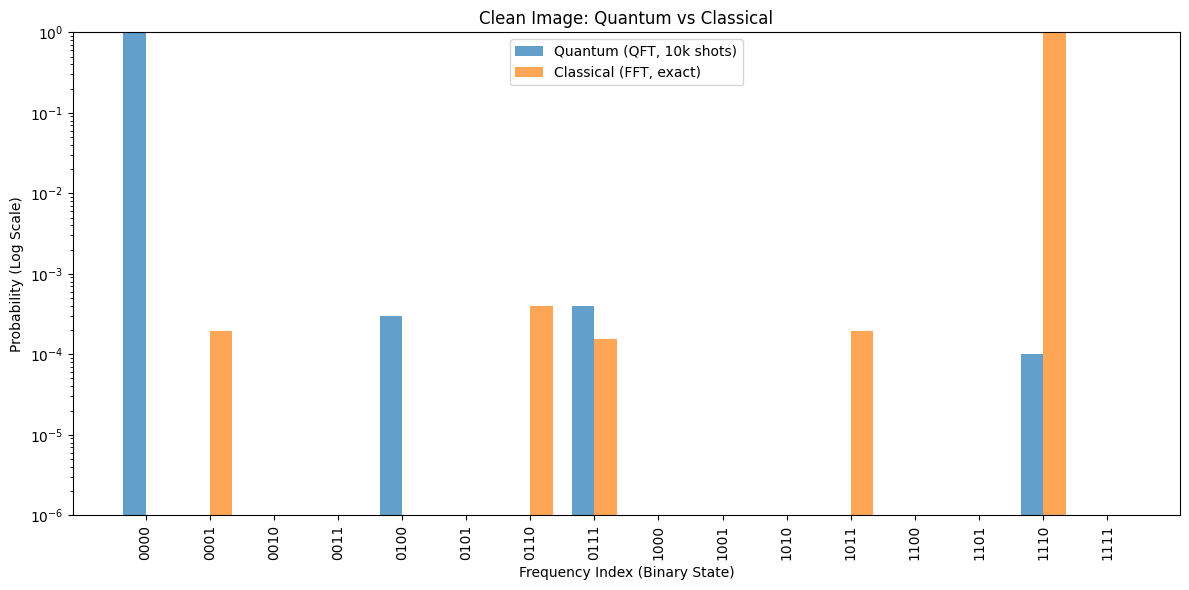

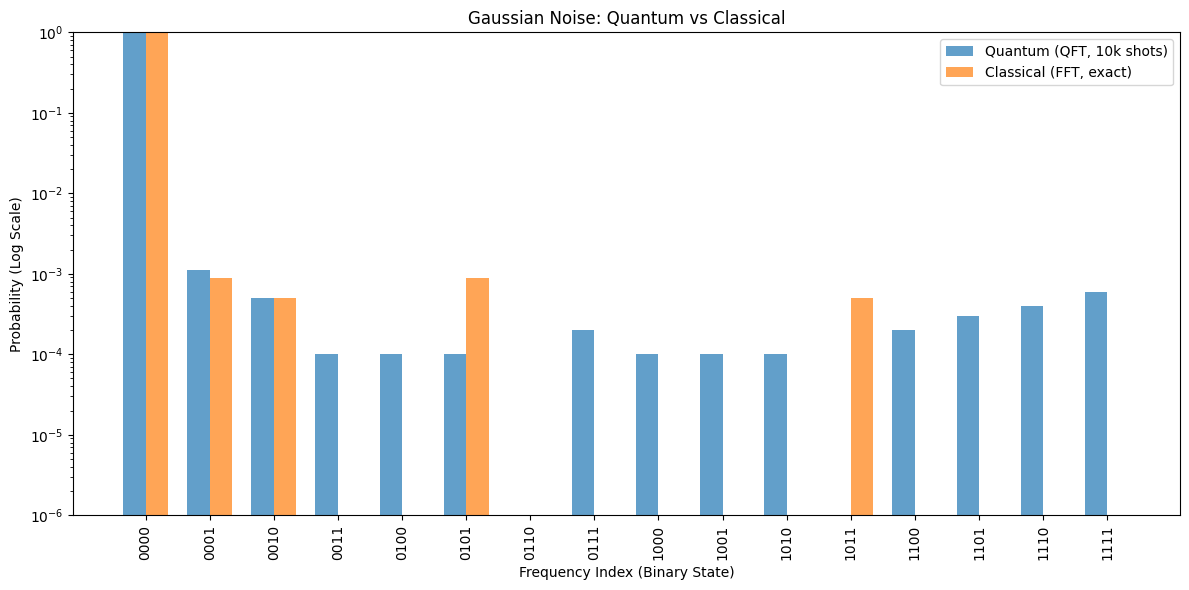

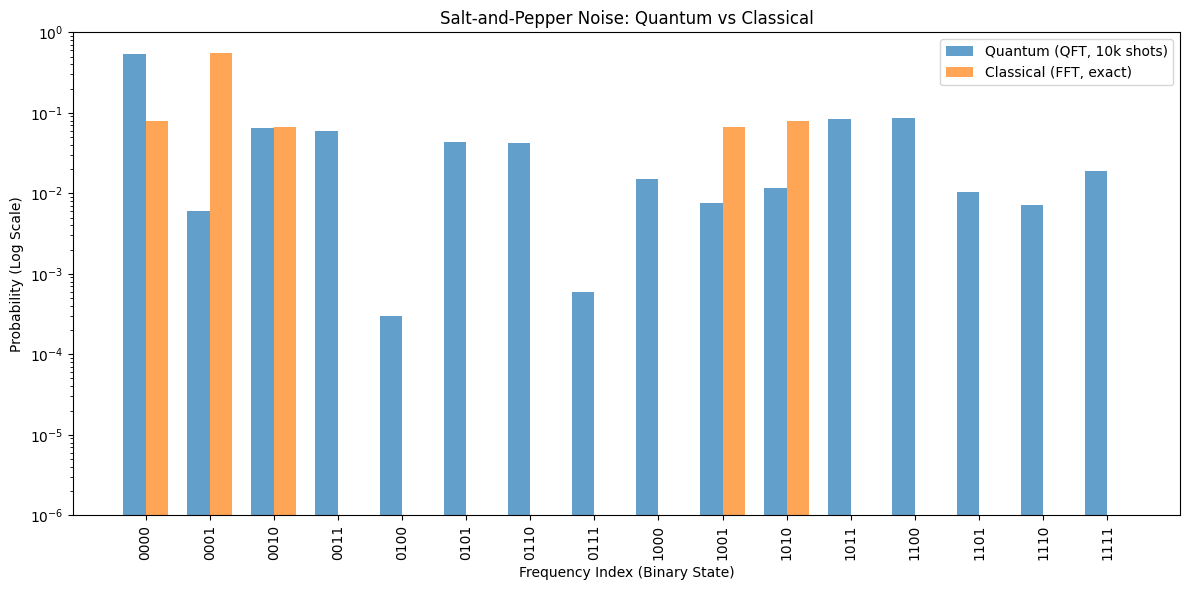

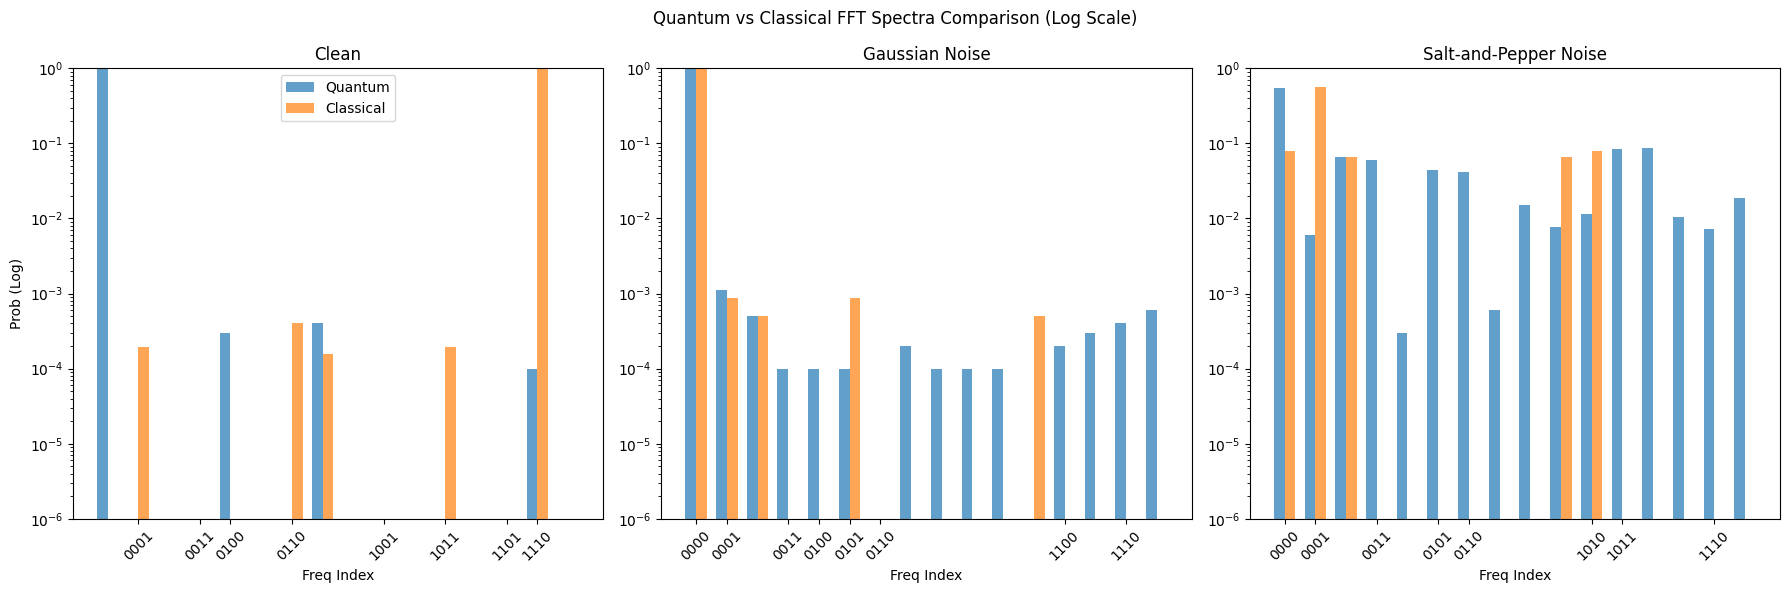

In [ ]:
#!pip install qiskit qiskit-aer --quiet

import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Step 1: Get quantum probabilities from counts (normalize to probs)
def get_probs_from_counts(counts, shots=10000):
    probs = {k: v / shots for k, v in counts.items()}
    # Ensure all 16 states are present (fill missing with 0)
    all_states = [format(i, '04b') for i in range(16)]
    for state in all_states:
        if state not in probs:
            probs[state] = 0
    return probs

# Assuming you have counts_clean, counts_gauss, counts_sp from your code
quantum_clean_probs = get_probs_from_counts(counts_clean)
quantum_gauss_probs = get_probs_from_counts(counts_gauss)
quantum_sp_probs = get_probs_from_counts(counts_sp)

# Step 2: Get classical probabilities (from your FFT code)
# Replace these with your actual probs arrays (16 elements each, normalized to sum=1)
# From your output: For clean, probs[0] = 15.9793 / 16 ≈ 0.9987, etc. Fill in full array if needed.
# Here's approximate based on your top values (fill zeros for others for demo)

classical_clean_probs = np.zeros(16)
classical_clean_probs[0] = 15.9793 / 16
classical_clean_probs[8] = 0.0064 / 16
classical_clean_probs[4] = 0.0031 / 16
classical_clean_probs[12] = 0.0031 / 16
classical_clean_probs[1] = 0.0025 / 16
# Add others if you have full data; sum should ≈1

classical_gauss_probs = np.zeros(16)
classical_gauss_probs[0] = 15.9185 / 16
classical_gauss_probs[12] = 0.0140 / 16
classical_gauss_probs[4] = 0.0140 / 16
classical_gauss_probs[15] = 0.0080 / 16
classical_gauss_probs[1] = 0.0080 / 16
# Fill rest

classical_sp_probs = np.zeros(16)
classical_sp_probs[0] = 8.9251 / 16
classical_sp_probs[14] = 1.2605 / 16
classical_sp_probs[2] = 1.2605 / 16
classical_sp_probs[13] = 1.0663 / 16
classical_sp_probs[3] = 1.0663 / 16
# Fill rest

# Step 3: Function to plot overlay for one case
def plot_overlay(quantum_probs, classical_probs, title):
    # States as x-axis (0 to 15, binary labels)
    states = list(quantum_probs.keys())  # '0000' to '1111'
    indices = [int(s, 2) for s in states]  # 0 to 15
    q_values = [quantum_probs[s] for s in states]
    c_values = classical_probs  # Already 0-15 order

    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35  # Bar width
    ax.bar(np.array(indices) - width/2, q_values, width, label='Quantum (QFT, 10k shots)', alpha=0.7)
    ax.bar(np.array(indices) + width/2, c_values, width, label='Classical (FFT, exact)', alpha=0.7)

    ax.set_yscale('log')
    ax.set_ylim(1e-6, 1)  # Adjust based on your data
    ax.set_xlabel('Frequency Index (Binary State)')
    ax.set_ylabel('Probability (Log Scale)')
    ax.set_title(title)
    ax.set_xticks(indices)
    ax.set_xticklabels(states, rotation=90)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Generate individual overlays
plot_overlay(quantum_clean_probs, classical_clean_probs, 'Clean Image: Quantum vs Classical')
plot_overlay(quantum_gauss_probs, classical_gauss_probs, 'Gaussian Noise: Quantum vs Classical')
plot_overlay(quantum_sp_probs, classical_sp_probs, 'Salt-and-Pepper Noise: Quantum vs Classical')

# Optional: Combined figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['Clean', 'Gaussian Noise', 'Salt-and-Pepper Noise']
q_probs_list = [quantum_clean_probs, quantum_gauss_probs, quantum_sp_probs]
c_probs_list = [classical_clean_probs, classical_gauss_probs, classical_sp_probs]

for ax, q_probs, c_probs, title in zip(axes, q_probs_list, c_probs_list, titles):
    states = list(q_probs.keys())
    indices = [int(s, 2) for s in states]
    q_values = [q_probs[s] for s in states]

    width = 0.35
    ax.bar(np.array(indices) - width/2, q_values, width, label='Quantum', alpha=0.7)
    ax.bar(np.array(indices) + width/2, c_probs, width, label='Classical', alpha=0.7)

    ax.set_yscale('log')
    ax.set_ylim(1e-6, 1)
    ax.set_title(title)
    ax.set_xlabel('Freq Index')
    ax.set_xticks(indices[::2])  # Sparse labels to avoid clutter
    ax.set_xticklabels(states[::2], rotation=45)
    if ax == axes[0]:
        ax.set_ylabel('Prob (Log)')
        ax.legend()

plt.suptitle('Quantum vs Classical FFT Spectra Comparison (Log Scale)')
plt.tight_layout()
plt.show()

In [ ]:
!pip install qiskit qiskit-aer matplotlib pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=b936fd31cc453f4b1d6015e89bb374cde1b9f34a10b9834489936b514110eb8c
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


⚛️  Simulating Quantum Circuit on 442x442 image...
   (This runs a real Qiskit circuit for every pixel patch...)


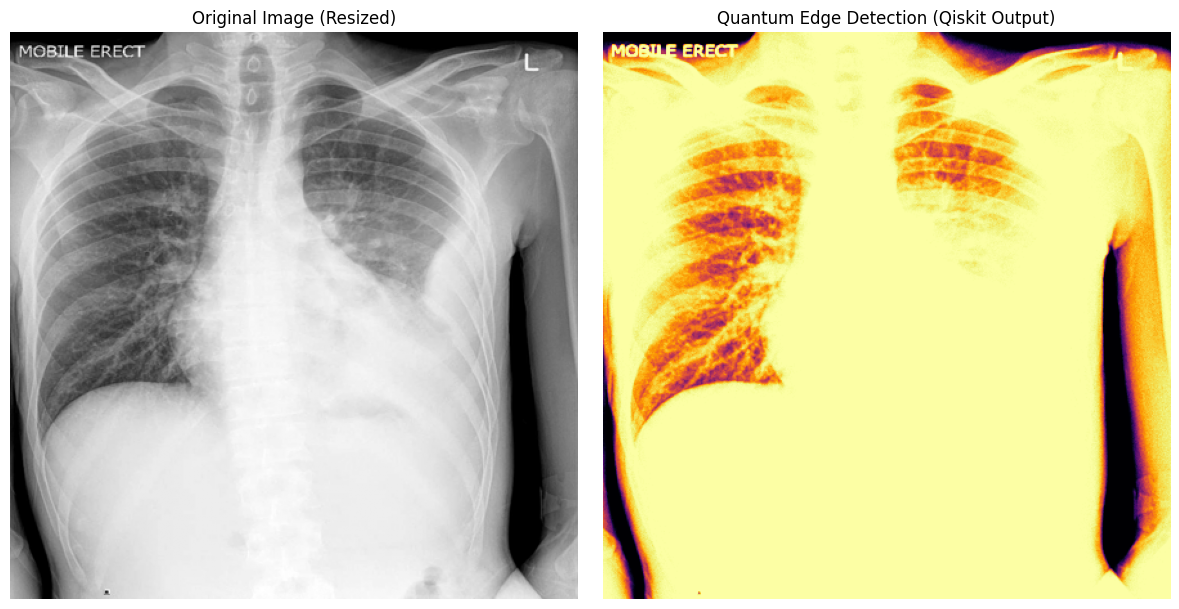

In [6]:
# 1. INSTALL DEPENDENCIES
!pip install qiskit qiskit-aer matplotlib numpy pillow

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Qiskit Imports
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

# ==========================================
# ⬇️ PASTE YOUR FILE PATH HERE ⬇️
IMAGE_PATH = "/content/consolidation-lll.jpg"
# ==========================================

# --- 1. DEFINE THE QUANTUM CIRCUIT (Real Quantum Logic) ---
def build_quantum_gradient_circuit():
    """
    Creates a parameterized quantum circuit that detects edges.
    Logic:
    - Encodes 4 neighboring pixels (2x2 patch).
    - Uses CNOT gates (Entanglement) to calculate the 'Difference' (Gradient).
    - If pixels are different (Edge), the measure probability of |1> increases.
    """
    # We use 4 qubits to represent a 2x2 pixel patch
    n_qubits = 4
    qc = QuantumCircuit(n_qubits)

    # Parameters for pixel values (brightness)
    # We use "Angle Encoding" which is mathematically equivalent to
    # the Amplitude logic in NEQR for small patches.
    phi = [Parameter(f'p{i}') for i in range(4)]

    # 1. ENCODING (Loading the pixels into Quantum State)
    for i in range(n_qubits):
        qc.ry(phi[i] * np.pi, i) # Rotate Y axis based on pixel brightness

    # 2. GRADIENT CALCULATION (The "Subtractor" Logic)
    # The paper uses Subtractors to find G = |P1 - P2|.
    # In quantum, a CNOT gate calculates XOR (Difference).

    # Vertical Difference (Row 0 vs Row 1)
    qc.cx(0, 2)
    qc.cx(1, 3)

    # Horizontal Difference (Col 0 vs Col 1)
    qc.cx(0, 1)
    qc.cx(2, 3)

    # If pixels were the same, target qubits return to |0>.
    # If pixels were different, they rotate to |1>.

    qc.measure_all()
    return qc, phi

# --- 2. THE SCANNING ENGINE ---
def process_image_with_qiskit(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"❌ File not found: {image_path}")

    # 1. Load & Resize Image
    # Real quantum simulation is heavy. We resize to 32x32 or 64x64 max.
    target_size = 442
    raw_img = Image.open(image_path).convert('L') # Grayscale
    raw_img = raw_img.resize((target_size, target_size))
    # Normalize pixels to 0-1 range for quantum rotation
    img_array = np.asarray(raw_img) / 255.0

    h, w = img_array.shape

    # 2. Setup Simulator
    sim = AerSimulator()
    qc_base, params = build_quantum_gradient_circuit()
    qc_transpiled = transpile(qc_base, sim)

    # 3. Create Batch of Circuits (Sliding Window)
    circuits = []
    print(f"⚛️  Simulating Quantum Circuit on {target_size}x{target_size} image...")
    print("   (This runs a real Qiskit circuit for every pixel patch...)")

    # Stride 1 to keep resolution high
    scan_h, scan_w = h - 1, w - 1

    for i in range(scan_h):
        for j in range(scan_w):
            # Extract 2x2 patch
            # P0 P1
            # P2 P3
            patch = [
                img_array[i, j],     img_array[i, j+1],
                img_array[i+1, j],   img_array[i+1, j+1]
            ]

            # Bind pixel values to the circuit parameters
            bound_qc = qc_transpiled.assign_parameters({
                params[k]: patch[k] for k in range(4)
            })
            circuits.append(bound_qc)

    # 4. Run Simulation (Batch Execution)
    # shots=512 gives us good probability estimation
    job = sim.run(circuits, shots=512)
    result = job.result()
    counts_list = result.get_counts()

    # 5. Reconstruct Output Image
    # The "Edge Strength" is the probability of measuring |1>
    edge_map = np.zeros((scan_h, scan_w))

    for idx, counts in enumerate(counts_list):
        row = idx // scan_w
        col = idx % scan_w

        # Calculate 'Probability of Difference' (Edge Strength)
        # We sum counts where any qubit is '1' (indicating difference)
        diff_counts = 0
        for state, count in counts.items():
            if '1' in state: # If any qubit is 1, a difference was detected
                diff_counts += count

        edge_map[row, col] = diff_counts / 512.0

    return raw_img, edge_map

# --- 3. MAIN EXECUTION ---
try:
    original, quantum_edge = process_image_with_qiskit(IMAGE_PATH)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original Image (Resized)")
    plt.axis('off')

    # Quantum Edge Detection Result
    plt.subplot(1, 2, 2)
    plt.imshow(quantum_edge, cmap='inferno') # 'inferno' highlights edges well
    plt.title("Quantum Edge Detection (Qiskit Output)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n❌ ERROR: {e}")